In [135]:
import onnxruntime as ort
import numpy as np
import cv2 as cv
from scipy.special import softmax
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2.functional import to_pil_image
import torch
import matplotlib.pyplot as plt

In [74]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [259]:
img = cv.imread('./data/example.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (640, 640))
img.shape

(640, 640, 3)

In [286]:
model_in = img / 255.0
# model_in = (model_in - mean) / std
model_in = model_in.transpose((2, 0, 1))
model_in = np.expand_dims(model_in, 0).astype(np.float32)

In [309]:
ort_session = ort.InferenceSession('./out/onnx/yolo11x.onnx')

In [310]:
outs = np.squeeze(ort_session.run(None, {'images': model_in})[0]).T

In [311]:
boxes_cxcywh = outs[:,:4].astype(np.int32)
boxes_xywh = np.vstack((boxes_cxcywh[:,0] - (boxes_cxcywh[:,2] / 2), boxes_cxcywh[:,1] - (boxes_cxcywh[:,3] / 2), boxes_cxcywh[:,2], boxes_cxcywh[:,3])).T
boxes_xyxy = np.vstack((boxes_xywh[:,0], boxes_xywh[:,1], boxes_xywh[:,0] + boxes_xywh[:,2], boxes_xywh[:,1] + boxes_xywh[:,3])).T

labels = outs[:,4:]
conf = labels.max(1)

nms = cv.dnn.NMSBoxes(boxes_xywh, conf, .25, .7)

boxes_xyxy = boxes_xyxy[nms,:]

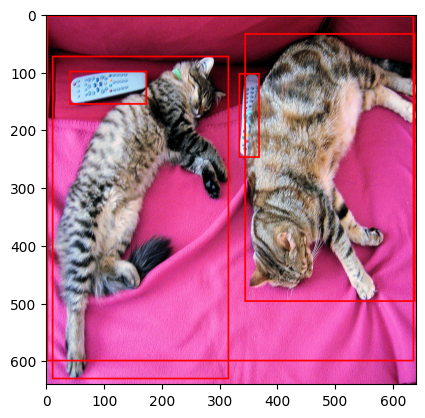

In [312]:
img_with_boxes = draw_bounding_boxes(torch.tensor(img.transpose((2, 0, 1))), boxes=torch.tensor(boxes_xyxy), colors="red", width=3)

plt.imshow(img_with_boxes.numpy().transpose((1, 2, 0)))
plt.show()